## Uncapacitated Facility Location problem

In [1]:
using Random, Statistics, LinearAlgebra

Random.seed!(79883274598)

nI = 100  # number of facilities
nJ = 100  # number of customers

# generate random problem instance
f = 0.5*ones(nI)
c = rand(nI,nJ)

using JuMP, Gurobi
m = Model(Gurobi.Optimizer)
#set_silent(m)

@variable(m, z[1:nI], Bin)         # binary constraint
# @variable(m, 0 <= z[1:nI] <= 1)    # LP relaxation

@variable(m, y[1:nI,1:nJ], Bin)     # binary constraint
#@variable(m, y[1:nI,1:nJ] >= 0)   # LP relaxation

@constraint(m, cc[j = 1:nJ], sum( y[i,j] for i=1:nI ) == 1)

# choose one of these two constraints (they are equivalent)
# @constraint(m, cr[i=1:nI], sum( y[i,j] for j=1:nJ ) <= nJ*z[i])
@constraint(m, cr[i=1:nI,j=1:nJ], y[i,j] <= z[i])

@objective(m, Min, dot(f,z) + dot(c,y))

@time(optimize!(m))

println(value.(z))
zopt=value.(z)
println("total number of facilities is ",sum(zopt))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10100 rows, 10100 columns and 30000 nonzeros
Model fingerprint: 0x8ee37752
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 83.0568764
Presolve time: 0.17s
Presolved: 10100 rows, 10100 columns, 30000 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)
Found heuristic solution: objective 58.7891725

Root relaxation: objective 8.998664e+00, 1736 iterations, 0.17 seconds (0.17 work units)

    Nodes    |    Current Node    |     Objective Bounds   

In [2]:
using JuMP, Gurobi, HiGHS

nvals = [5,10,15,20,25,30,35,40,45,50]
tt_highs = zeros(length(nvals),50)
tt_gurobi = zeros(length(nvals),50)
;

In [3]:
t = tt_highs
for count = 1:10
    println(count)
    for (k,n) in enumerate(nvals)
        nI = n  # number of facilities
        nJ = n  # number of customers

        # generate random problem instance
        Random.seed!(count)
        f = 0.5*ones(nI)
        c = rand(nI,nJ)

        m = Model(HiGHS.Optimizer)
        set_silent(m)

        @variable(m, x[1:nI], Bin)         # binary constraint
        @variable(m, y[1:nI,1:nJ] >= 0)    # LP relaxation
        @constraint(m, cc[j = 1:nJ], sum( y[i,j] for i=1:nI ) == 1)
        @constraint(m, cr[i=1:nI,j=1:nJ], y[i,j] <= x[i])
        @objective(m, Min, dot(f,x) + dot(vec(c),vec(y)))
        t[k,count] = @timed(optimize!(m))[2]
    end
end

1
2
3
4
5
6
7
8
9
10


In [4]:
t = tt_gurobi
for count = 1:10
    println(count)
    for (k,n) in enumerate(nvals)
        nI = n  # number of facilities
        nJ = n  # number of customers

        # generate random problem instance
        Random.seed!(count)
        f = 0.5*ones(nI)
        c = rand(nI,nJ)

        m = Model(Gurobi.Optimizer)
        set_silent(m)

        @variable(m, x[1:nI], Bin)         # binary constraint
        @variable(m, y[1:nI,1:nJ] >= 0)    # LP relaxation
        @constraint(m, cc[j = 1:nJ], sum( y[i,j] for i=1:nI ) == 1)
        @constraint(m, cr[i=1:nI,j=1:nJ], y[i,j] <= x[i])
#         @objective(m, Min, dot(f,x) + vecdot(c,y))
         @objective(m, Min, dot(f,x) + dot(vec(c),vec(y)))
        t[k,count] = @timed(optimize!(m))[2]
    end
end

1
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
2
Set parameter Username
Academic license - for non-commercial use only - expires 2025-0

In [5]:
# println(tt_gurobi)
# for (k,n) in enumerate(nvals)
#     println(k, ":", n)
# end 

tt_highs_mean = []
for (k,n) in enumerate(nvals)
    x = tt_highs[k,:]
    x = [j for j in x if j > 0]
    append!(tt_highs_mean, mean(x))
end

tt_gurobi_mean = []
for (k,n) in enumerate(nvals)
    x = tt_gurobi[k,:]
    x = [j for j in x if j > 0]
    append!(tt_gurobi_mean, mean(x))
end
println(tt_gurobi_mean)
println(tt_highs_mean)


#tt_gurobi_mean = mean(tt_gurobi,2)

# tt_highs_mean = mean(tt_highs,2)




Any[0.0139897038, 0.0033421708, 0.007022236999999999, 0.012546297500000001, 0.021039462000000002, 0.047010245699999995, 0.14756940960000003, 0.12274563369999998, 0.3124390464, 0.419829863]
Any[0.0458652936, 0.004366283699999999, 0.029970446, 0.0602816118, 0.1277438704, 0.390563087, 1.1373688387, 1.2369265781, 2.5603670315000002, 3.233858959]


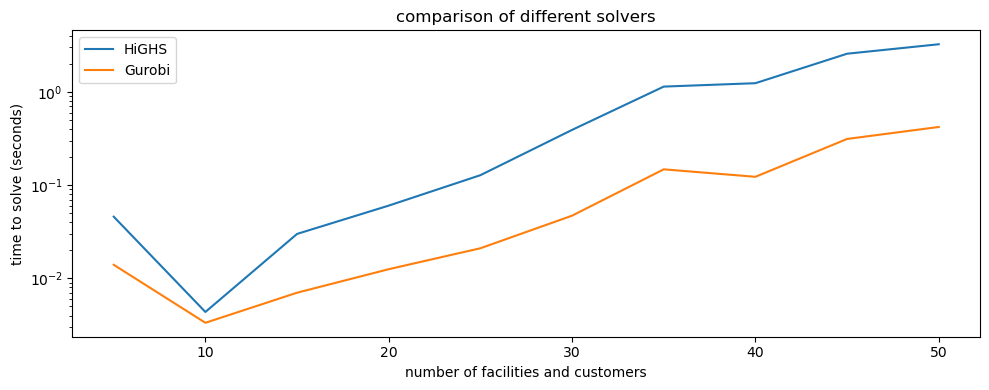

In [6]:
using PyPlot

figure(figsize=(10,4))
semilogy(nvals,tt_highs_mean,label="HiGHS")
semilogy(nvals,tt_gurobi_mean,label="Gurobi")
legend(loc="best")
xlabel("number of facilities and customers")
ylabel("time to solve (seconds)")
title("comparison of different solvers")
tight_layout()

display(gcf())

#savefig("solver_comparison.pdf")
;